# Fingerprint BigGAN

View source on [GitHub](https://github.com/Luksalos/BIO-fingerprint-GAN/). Based on [this Kaggle kernel](https://www.kaggle.com/yukia18/sub-rals-ac-biggan-with-minibatchstddev). [Model description](https://www.kaggle.com/c/generative-dog-images/discussion/104211#latest-601531).

## Getting the dataset

Download the SOCOFing dataset (`socofing.zip`) from [Kaggle](https://www.kaggle.com/ruizgara/socofing).

## Configuration

Here you can tweak parameters of the model and specify where you want to run computations and store dataset with results.

You can choose between Google Colab with Google Drive, or your local machine:

### Using Google Colab and Google Drive

If the config below contains `'use_google_drive': True`, you will be asked to provide access to your Google Drive.

Your Google Drive should contain the `socofing.zip` file at the top level. This notebook extracts the archive to disk of the Colab runtime, meaning your Google Drive will not be affected.

Checkpoints of the GAN and generated samples will be stored in your Drive in the `BigGAN_outputs/` directory.

### Using your local machine

If the config below contains `'use_google_drive': False`, the `socofing.zip` file should be located in your home directory.

The archive will be extracted to `~/socofing/`, checkpoints of the GAN and generated samples will be stored in the `~/BigGAN_outputs/` directory.

In [0]:
config = {
    'DataLoader': {
        'batch_size': 128,
        'shuffle': True,
    },
    'Generator': {
        'latent_dim': 120,
        'embed_dim': 8,
        'ch': 64,
        'num_classes': 20,
        'use_attn': True,
    },
    'Discriminator': {
        'ch': 64,
        'num_classes': 20,
        'use_attn': True,
    },
    'sample_latents': {
        'latent_dim': 120,
        'num_classes': 20,
    },
    'num_iterations': 25000,
    'decay_start_iteration': 20000,
    'd_steps': 1,
    'lr_G': 2e-4,
    'lr_D': 4e-4,
    'betas': (0.0, 0.999),
    'margin': 1.0,
    'gamma': 0.1,
    'ema': 0.999,
    'seed': 42,
    # 'input_transformation': 'resize-64',          # resize - 64x64
    #  'input_transformation': 'crop-64',            # crop - 64x64
    #  'input_transformation': 'random-crop-64',     # crop - 64x64
    #  'input_transformation': 'crop-80',            # crop - 80x80
    'input_transformation': 'crop-96',            # crop - 96x96
    'use_google_drive': True,
}

## Libraries and directories setup

In [0]:
import os
import random
import glob
import shutil
import warnings
import math
import pprint
import zipfile
import pathlib

import cv2
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import xml.etree.ElementTree as ET
import albumentations as A
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from albumentations.pytorch import ToTensor
from tqdm import tqdm_notebook, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid, save_image
from torchsummary import summary

In [0]:
%matplotlib inline
warnings.filterwarnings('ignore', category=FutureWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [47]:
if device == 'cuda':
    !nvidia-smi

Thu Dec 12 11:36:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    36W / 250W |  14569MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config['seed'])

In [49]:
if config['use_google_drive']:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
BASE_PATH = '/content/drive/My Drive' if config['use_google_drive'] else str(pathlib.Path.home())
DATASET_BASE_DIR = '/content' if config['use_google_drive'] else str(pathlib.Path.home())
DATASET_ZIP = f'{BASE_PATH}/socofing.zip'
DATASET_DIR = f'{DATASET_BASE_DIR}/socofing'
DATASET_IMAGES = f'{DATASET_DIR}/SOCOFing/Real'

if not os.path.exists(DATASET_DIR):
    with zipfile.ZipFile(DATASET_ZIP, 'r') as file:
        file.extractall(DATASET_DIR)

OUT_BASE_PATH = f'{BASE_PATH}/BigGAN_outputs/{config["input_transformation"]}'
CHECKPOINTS_PATH = f'{OUT_BASE_PATH}/model'
GEN_IMGS_PATH = f'{OUT_BASE_PATH}/images'

os.makedirs(CHECKPOINTS_PATH, exist_ok=True)
os.makedirs(GEN_IMGS_PATH, exist_ok=True)

In [51]:
all_files = os.listdir(DATASET_IMAGES)
all_files[:5]

['329__M_Right_index_finger.BMP',
 '197__M_Left_thumb_finger.BMP',
 '299__M_Left_thumb_finger.BMP',
 '471__M_Right_little_finger.BMP',
 '419__F_Right_little_finger.BMP']

# Data processing

In [0]:
# functions for images visualization
def examine_imgs(procces_img_func, data, columns=4, size=10, show_title=True):
    rows = len(data) / columns + 1
    figsize = (size*columns, size*rows)
    f = plt.figure(figsize=figsize)
    for i, image in enumerate(data):
        img = procces_img_func(image)
        sp = f.add_subplot(rows, columns, i+1)
        sp.axis('Off')
        if show_title:
            title_text = str(i)
            # if items in data are type of string
            # if isinstance(image, str):
            #     title_text += image
            sp.set_title(title_text, fontsize=18)
        plt.imshow(img)
    plt.show()

def identity(image):
    return image

def unnormalize(image):
    # inverse operation for A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # WARNING!: works only for A.Normalize with exactly these used parameters
    return np.round(np.clip(((image + 1)/2)*255,0,255)).astype(int)[...,::-1]

def loader(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

### Visualize some raw images


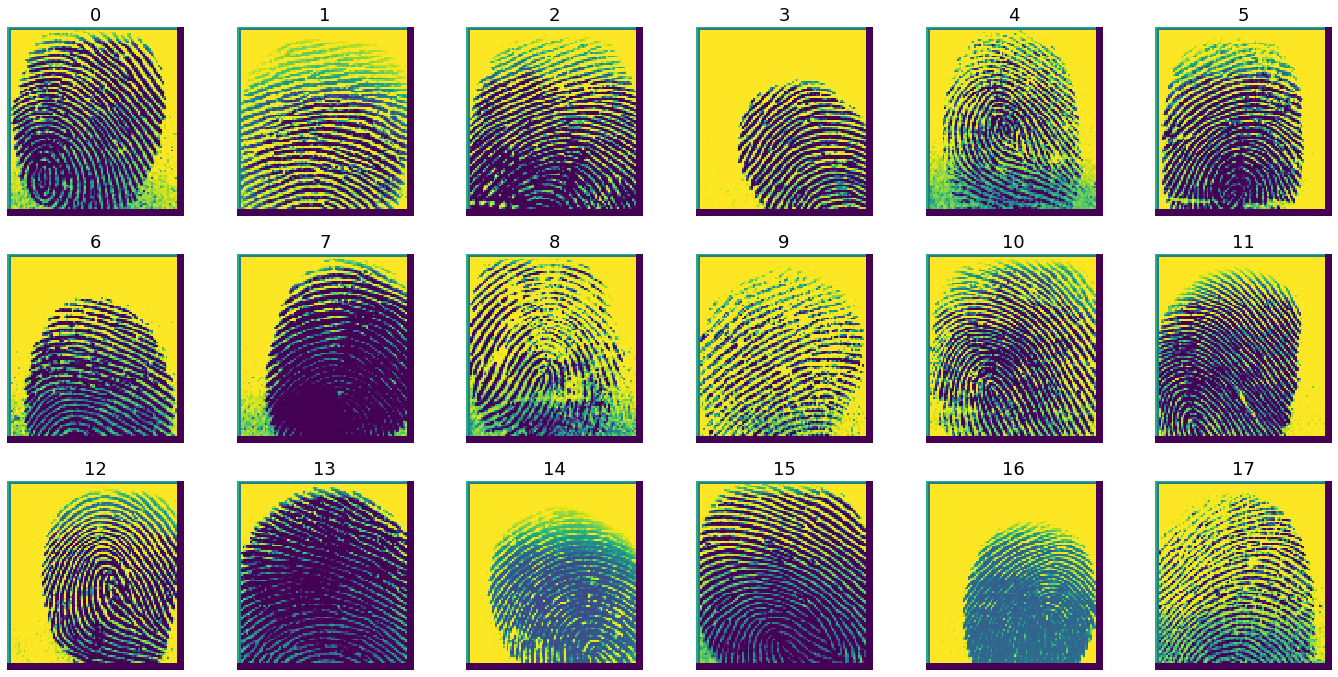

In [53]:
num_to_show = 18
full_paths = [os.path.join(DATASET_IMAGES, image_name) for image_name in all_files[:num_to_show]]
examine_imgs(loader, full_paths, columns=6, size=4)

### Strange borders

As we can see on the pictures above, for some reason they have strange borders, so lets remove them:

image shape: (103, 96)
Top left corner:
array([[160, 160, 160, 160, 160, 160, 160, 160],
       [160, 105, 105, 105, 105, 105, 105, 105],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255],
       [160, 105, 255, 255, 255, 255, 255, 255]], dtype=uint8)
Botom right corner:
array([[235, 231, 241, 181,   0,   0,   0,   0],
       [138, 232, 250, 224,   0,   0,   0,   0],
       [199, 208, 250, 228,   0,   0,   0,   0],
       [220, 229, 176, 238,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)


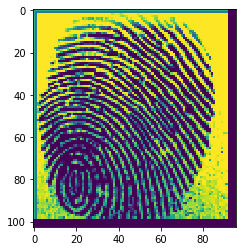

In [54]:
first_img = cv2.imread(full_paths[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(first_img)
print(f'image shape: {first_img.shape}')
print("Top left corner:")
pprint.pprint(first_img[:8,:8])
print("Botom right corner:")
pprint.pprint(first_img[95:103,88:96])

To get nice images we remove 2 pixels from top and left side, remove 4 pixel from bottom and right side.

image shape: (97, 90)


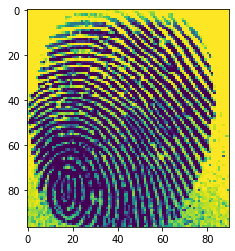

In [55]:
croped_img = first_img[2:99,2:92]
plt.imshow(croped_img)
print(f'image shape: {croped_img.shape}')

In [0]:
def load_image(file, transformation):
    img = cv2.imread(os.path.join(DATASET_IMAGES, file))

    # Resize - 64x64
    if transformation == 'resize-64':
        img = img[2:99,2:92]
        transform = A.Compose([A.Resize(64, 64, interpolation=cv2.INTER_AREA),
                               A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Crop - 64x64
    elif transformation == 'crop-64':
        img = img[2:99,2:92]
        img = img[33:97,16:80]
        transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Crop - 80x80
    elif transformation == 'crop-80':
        img = img[2:99,2:92]
        img = img[17:97,5:85] 
        transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Crop - 96x96
    elif transformation == 'crop-96':
        img = img[3:99,:96]  
        img[:,:2,:] = 0 # set right border to 0 (to be the same as the right side)
        transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Random Crop during augmentation
    elif transformation == 'random-crop-64':
        img = img[2:99,2:92]
        transform = A.Compose([A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    else:
        raise Error('Unknown input transformation specified.')

    return transform(image=img)['image']

all_images = [load_image(f, config['input_transformation']) for f in all_files]
all_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[:, :, np.newaxis] for img in all_images]
all_images = np.array(all_images)

In [0]:
# For Debugging, cv2.IMREAD_GRAYSCALE
# first_img = cv2.imread(full_paths[0])
# croped_img = first_img[3:99,:96]
# croped_img[:,:2,:] = 0
# plt.imshow(croped_img)
# print(f'image shape: {croped_img.shape}')

In [58]:
def extract_label(file):
    _, label = file.split('__', 1)
    label, _ = label.split('.', 1)
    return label

all_labels = [extract_label(f) for f in all_files]
all_labels = LabelEncoder().fit_transform(all_labels)
all_labels[:5]

array([15, 14, 14, 16,  6])

In [0]:
class FingerprintDataset(Dataset):
    def __init__(self, images, labels, transformation):
        super().__init__()
        self.images = images
        self.labels = labels
        # self.transform = A.Compose([A.HorizontalFlip(p=0.5), ToTensor()])
        # # Crop random 64x64 patches
        if transformation == 'random-crop-64':
            self.transform = A.Compose([A.RandomCrop(height=64, width=64), ToTensor()])
        else:
            self.transform = A.Compose([ToTensor()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img = self.transform(image=img)['image']
        label = torch.as_tensor(label, dtype=torch.long)

        return img, label

In [0]:
# adding uniform noise works well.

def get_dataiterator(images, labels, transformation, dataloader_params, device='cpu'):
    train_dataset = FingerprintDataset(images, labels, transformation)
    train_dataloader = DataLoader(train_dataset, **dataloader_params)
    batch_size = dataloader_params['batch_size']

    while True:
        for imgs, labels in train_dataloader:
            if batch_size != imgs.size(0):
                break
            else:
                imgs, labels = imgs.to(device), labels.to(device)
                imgs += (1.0 / 128.0) * torch.rand_like(imgs)

                yield imgs, labels

In [0]:
# batch size around 64 ~ 128 improves score.
# ~ 64 are too small, 128 ~ are too large (for 9 hours training). 

train_dataiterator = get_dataiterator(all_images, all_labels, config['input_transformation'], config['DataLoader'], device=device)

### Visualize some processed images

In [0]:
real_imgs, _ = train_dataiterator.__next__()

In [63]:
real_imgs[0].shape

torch.Size([1, 96, 96])

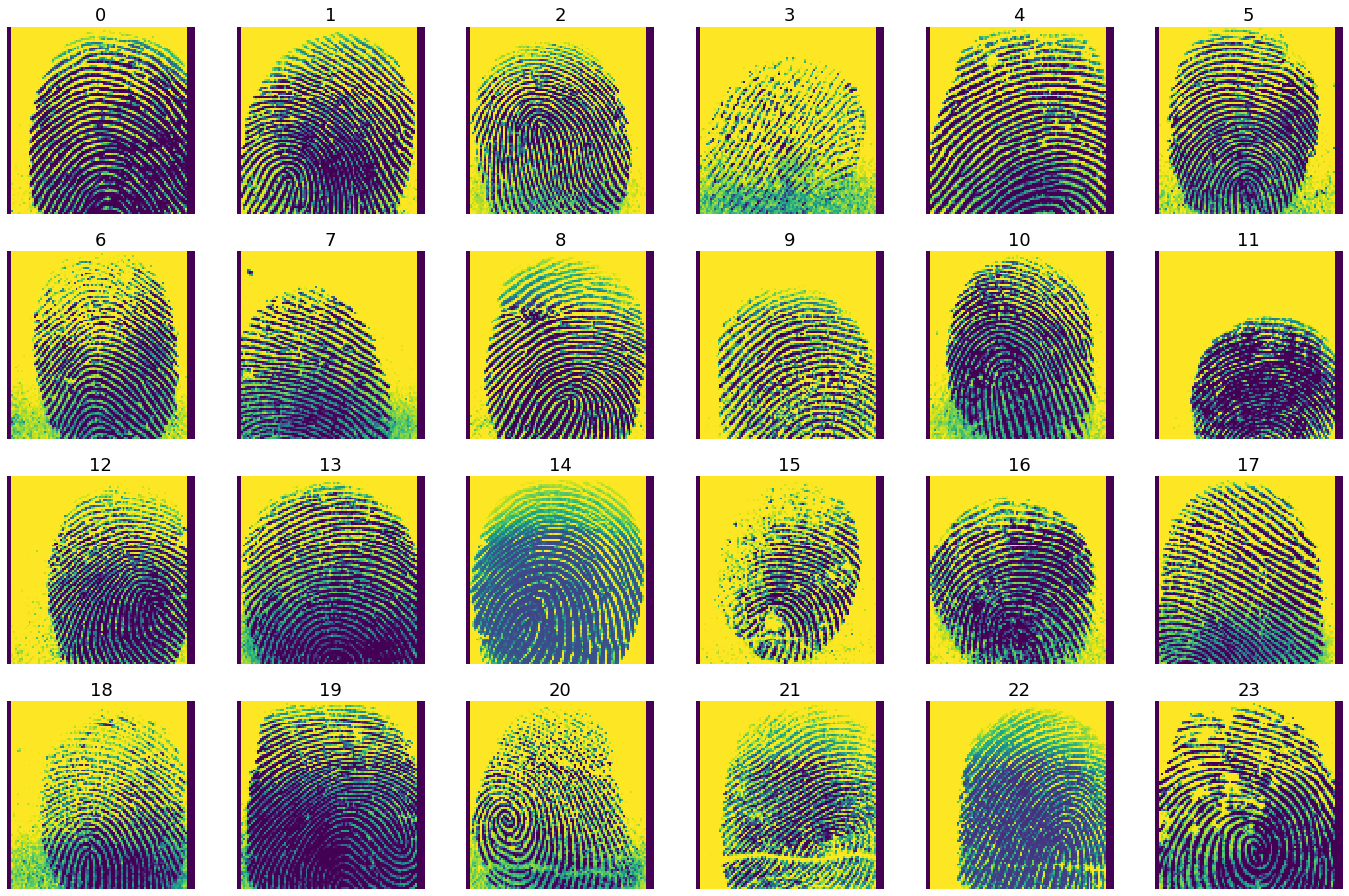

In [64]:
# TODO clip data to valid range...
examine_imgs(identity, real_imgs[:,0,:,:].add_(1).div_(2).cpu().detach().numpy()[:24], columns=6, size=4)

# Models

In [0]:
# Attention slightly works.

class Attention(nn.Module):
    def __init__(self, channels, reduction_attn=8, reduction_sc=2):
        super().__init__()
        self.channles_attn = channels // reduction_attn
        self.channels_sc = channels // reduction_sc
        
        self.conv_query = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_key = spectral_norm(nn.Conv2d(channels, self.channles_attn, kernel_size=1, bias=False))
        self.conv_value = spectral_norm(nn.Conv2d(channels, self.channels_sc, kernel_size=1, bias=False))
        self.conv_attn = spectral_norm(nn.Conv2d(self.channels_sc, channels, kernel_size=1, bias=False))
        self.gamma = nn.Parameter(torch.zeros(1))
        
        nn.init.orthogonal_(self.conv_query.weight.data)
        nn.init.orthogonal_(self.conv_key.weight.data)
        nn.init.orthogonal_(self.conv_value.weight.data)
        nn.init.orthogonal_(self.conv_attn.weight.data)

    def forward(self, x):
        batch, _, h, w = x.size()
        
        proj_query = self.conv_query(x).view(batch, self.channles_attn, -1)
        proj_key = F.max_pool2d(self.conv_key(x), 2).view(batch, self.channles_attn, -1)
        
        attn = torch.bmm(proj_key.permute(0,2,1), proj_query)
        attn = F.softmax(attn, dim=1)
        
        proj_value = F.max_pool2d(self.conv_value(x), 2).view(batch, self.channels_sc, -1)
        attn = torch.bmm(proj_value, attn)
        attn = attn.view(batch, self.channels_sc, h, w)
        attn = self.conv_attn(attn)
        
        out = self.gamma * attn + x
        
        return out

## Generator

In [0]:
# using label information works well.
# As for generator, it is realized by conditional batch normalization.

class CBN2d(nn.Module):
    def __init__(self, num_features, num_conditions):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = spectral_norm(nn.Conv2d(num_conditions, num_features*2, kernel_size=1, bias=False))
        
        nn.init.orthogonal_(self.embed.weight.data)

    def forward(self, x, y):
        out = self.bn(x)
        embed = self.embed(y.unsqueeze(2).unsqueeze(3))
        gamma, beta = embed.chunk(2, dim=1)
        out = (1.0 + gamma) * out + beta 

        return out

In [0]:
# residual block improves convergence speed and generated image's quality.
# nearest upsampling is better than others.

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conditions, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.cbn1 = CBN2d(in_channels, num_conditions)
        self.cbn2 = CBN2d(out_channels, num_conditions)
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()

        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)
    
    def _upsample_conv(self, x, conv):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = conv(x)
        
        return x
    
    def _residual(self, x, y):
        x = self.relu(self.cbn1(x, y))
        x = self._upsample_conv(x, self.conv1) if self.upsample else self.conv1(x)
        x = self.relu(self.cbn2(x, y))
        x = self.conv2(x)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            x = self._upsample_conv(x, self.conv_sc) if self.upsample else self.conv_sc(x)
            
        return x
    
    def forward(self, x, y):
        return self._shortcut(x) + self._residual(x, y)

In [0]:
# shared embedding of class labels, and hierarchical latent noise, work well.
# this architecture is the same as BigGAN except for channel size.

class Generator(nn.Module):
    def __init__(self, latent_dim, ch, num_classes, embed_dim, use_attn=False):
        super().__init__()
        self.latent_dim = latent_dim
        self.ch = ch
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.use_attn = use_attn
        self.num_chunk = 5
        num_latents = self.__get_num_latents()
        
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.fc = spectral_norm(nn.Linear(num_latents[0], ch*8*6*6, bias=False))
        self.block1 = GBlock(ch*8, ch*8, num_latents[1], upsample=True)
        self.block2 = GBlock(ch*8, ch*4, num_latents[2], upsample=True)
        self.block3 = GBlock(ch*4, ch*2, num_latents[3], upsample=True)
        if use_attn:
            self.attn = Attention(ch*2)
        self.block4 = GBlock(ch*2, ch, num_latents[4], upsample=True)
        self.bn = nn.BatchNorm2d(ch)
        self.relu = nn.ReLU()
        self.conv_last = spectral_norm(nn.Conv2d(ch, 1, kernel_size=3, padding=1, bias=False))
        self.tanh = nn.Tanh()
        
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.conv_last.weight.data)
        nn.init.constant_(self.bn.weight.data, 1.0)
        nn.init.constant_(self.bn.bias.data, 0.0)
    
    def __get_num_latents(self):
        xs = torch.empty(self.latent_dim).chunk(self.num_chunk)
        num_latents = [x.size(0) for x in xs]
        for i in range(1, self.num_chunk):
            num_latents[i] += self.embed_dim
        
        return num_latents
    
    def forward(self, x, y):
        xs = x.chunk(self.num_chunk, dim=1)
        y = self.embed(y)
        
        h = self.fc(xs[0])
        h = h.view(h.size(0), self.ch*8, 6, 6)
        h = self.block1(h, torch.cat([y, xs[1]], dim=1))
        h = self.block2(h, torch.cat([y, xs[2]], dim=1))
        h = self.block3(h, torch.cat([y, xs[3]], dim=1))
        if self.use_attn:
            h = self.attn(h)
        h = self.block4(h, torch.cat([y, xs[4]], dim=1))
        h = self.relu(self.bn(h))
        out = self.tanh(self.conv_last(h))
        
        return out

## Discriminator

In [0]:
# residual block improves convergence speed and generated image's quality.

class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, optimized=False):
        super().__init__()
        self.downsample = downsample
        self.optimized = optimized
        self.learnable_sc = in_channels != out_channels or downsample
        
        self.conv1 = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
        if self.learnable_sc:
            self.conv_sc = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        self.relu = nn.ReLU()
        
        nn.init.orthogonal_(self.conv1.weight.data)
        nn.init.orthogonal_(self.conv2.weight.data)
        if self.learnable_sc:
            nn.init.orthogonal_(self.conv_sc.weight.data)

    def _residual(self, x):
        if not self.optimized:
            x = self.relu(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        
        return x
    
    def _shortcut(self, x):
        if self.learnable_sc:
            if self.optimized:
                x = self.conv_sc(F.avg_pool2d(x, 2)) if self.downsample else self.conv_sc(x)
            else:
                x = F.avg_pool2d(self.conv_sc(x), 2) if self.downsample else self.conv_sc(x)
        
        return x
    
    def forward(self, x):
        return self._shortcut(x) + self._residual(x)

In [0]:
# this architecture is the altered version of BigGAN Discriminator.
# <- using residual block, projection.

# but those points are different from original.
# - reduce channel size.
# - reduce model depth (remove last residual block).
# - add minibatch stddev.
# - with auxiliary classifier (ACGAN).
#   <- improve image's quality and stabilize training.

class Discriminator(nn.Module):
    def __init__(self, ch, num_classes, use_attn=False):
        super().__init__()
        self.ch = ch
        self.num_classes = num_classes
        self.use_attn = use_attn
        
        self.block1 = DBlock(1, ch, downsample=True, optimized=True)
        if use_attn:
            self.attn = Attention(ch)
        self.block2 = DBlock(ch, ch*2, downsample=True)
        self.block3 = DBlock(ch*2, ch*4, downsample=True)
        self.block4 = DBlock(ch*4, ch*8, downsample=True)
        self.block5 = DBlock(ch*8+1, ch*8, downsample=False)
        self.relu = nn.ReLU()
        self.fc = spectral_norm(nn.Linear(ch*8, 1, bias=False))
        self.embed = spectral_norm(nn.Embedding(num_classes, ch*8))
        self.clf = spectral_norm(nn.Linear(ch*8, num_classes, bias=False))
        
        nn.init.orthogonal_(self.fc.weight.data)
        nn.init.orthogonal_(self.embed.weight.data)
        nn.init.orthogonal_(self.clf.weight.data)
    
    def minibatch_stddev(self, x, group_size=4, eps=1e-8):
        shape = x.size()
        y = x.view(group_size, -1, shape[1], shape[2], shape[3])
        y -= torch.mean(y, dim=0, keepdim=True)
        y = torch.mean(y.pow(2), dim=0)
        y = torch.sqrt(y + eps)
        y = torch.mean(y, dim=[1,2,3], keepdim=True)
        y = y.repeat(group_size, 1, shape[2], shape[3])

        return torch.cat([x, y], dim=1)
    
    def forward(self, x, y):
        h = self.block1(x)
        if self.use_attn:
            h = self.attn(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.block5(self.minibatch_stddev(h))
        h = self.relu(h)
        h = torch.sum(h, dim=(2,3))
        
        out = self.fc(h)
        out += torch.sum(self.embed(y)*h, dim=1, keepdim=True)
        
        ac = self.clf(h)
        ac = F.log_softmax(ac, dim=1)
        
        return out, ac

# Train GANs

In [0]:
netG = Generator(**config['Generator']).to(device, torch.float32)
netD = Discriminator(**config['Discriminator']).to(device, torch.float32)

In [0]:
# Model summary doesn't work, for this models
# Got error: "TypeError: rand() argument after * must be an iterable, not int"
# There is solution, but in colab cannot edit library :(
# https://github.com/sksq96/pytorch-summary/issues/53
# https://github.com/sksq96/pytorch-summary/issues/102
# summary(netG, [(1, 120), (1)])
# summary(netD, [(1, 3, 96, 96),(1)])

In [0]:
optim_G = Adam(params=netG.parameters(), lr=config['lr_G'], betas=config['betas'])
optim_D = Adam(params=netD.parameters(), lr=config['lr_D'], betas=config['betas'])

In [0]:
decay_iter = config['num_iterations'] - config['decay_start_iteration']
if decay_iter > 0:
    lr_lambda_G = lambda x: (max(0,1-x/decay_iter))
    lr_lambda_D = lambda x: (max(0,1-x/(decay_iter*config['d_steps'])))
    lr_sche_G = LambdaLR(optim_G, lr_lambda=lr_lambda_G)
    lr_sche_D = LambdaLR(optim_D, lr_lambda=lr_lambda_D)

In [0]:
def calc_advloss_D(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() - margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() + margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [0]:
def calc_advloss_G(real, fake, margin=1.0):
    loss_real = torch.mean((real - fake.mean() + margin) ** 2)
    loss_fake = torch.mean((fake - real.mean() - margin) ** 2)
    loss = (loss_real + loss_fake) / 2
    
    return loss

In [0]:
# auxiliary classifier loss.
# this loss weighted by gamma (0.1) is added to adversarial loss.
# coefficient gamma is quite sensitive.

criterion = nn.NLLLoss().to(device, torch.float32)

In [0]:
def sample_latents(batch_size, latent_dim, num_classes):
    latents = torch.randn((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels = torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    return latents, labels

In [0]:
def truncated_normal(size, threshold=2.0, dtype=torch.float32, device='cpu'):
    x = scipy.stats.truncnorm.rvs(-threshold, threshold, size=size)
    x = torch.from_numpy(x).to(device, dtype)

    return x

In [0]:
def generate_eval_samples(generator, batch_size, latent_dim, num_classes):
    latents = truncated_normal((batch_size, latent_dim), dtype=torch.float32, device=device)
    labels =  torch.randint(0, num_classes, size=(batch_size,), dtype=torch.long, device=device)
    
    with torch.no_grad():
        imgs = (generator(latents, labels) + 1) / 2
    
    return imgs

In [0]:
def gen_and_save_some_images(step, repeatch_each_class=2, nrow=8):
    split_size = 50

    latent_dim = config['sample_latents']['latent_dim']
    num_classes = config['sample_latents']['num_classes']

    all_labels = torch.arange(num_classes, dtype=torch.long, device=device)
    all_labels = all_labels.repeat_interleave(repeatch_each_class)
    labels_split = all_labels.split(split_size)

    imgs_list = []
    for labels in labels_split:
        batch_size = labels.size(0)
        latents = truncated_normal((batch_size, latent_dim), threshold=1.5, dtype=torch.float32, device=device)
        with torch.no_grad():
            # imgs = (netGE(latents, labels) + 1) / 2
            imgs = (netG(latents, labels) + 1) / 2
            imgs_list.append(imgs)

    all_imgs = torch.cat(imgs_list, dim=0)
    all_imgs = make_grid(all_imgs, nrow=nrow, normalize=False)
    all_imgs = all_imgs.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()

    img.imsave(f'{GEN_IMGS_PATH}/step-{step:05}.png', all_imgs)
    # plt.figure(figsize=(2*nrow, 2*(num_classes*repeatch_each_class)//nrow))
    # plt.imshow(all_imgs);

In [0]:
def save_checkpoint(step, netG, netD, optim_G, optim_D):
    torch.save({'step': step,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'optim_G_state_dict': optim_G.state_dict(),
                'optim_D_state_dict': optim_D.state_dict(),
                }, f'{CHECKPOINTS_PATH}/params-{step:05}.pt')

In [0]:
def load_last_checkpoint(netG, netD, optim_G, optim_D):
    all_checkpoints = glob.glob(f'{CHECKPOINTS_PATH}/params-*.pt')

    if not all_checkpoints:
        return 0

    all_checkpoints.sort(reverse=True)
    last_checkpoint = torch.load(all_checkpoints[0])

    netG.load_state_dict(last_checkpoint['netG_state_dict'])
    netD.load_state_dict(last_checkpoint['netD_state_dict'])
    optim_G.load_state_dict(last_checkpoint['optim_G_state_dict'])
    optim_D.load_state_dict(last_checkpoint['optim_D_state_dict'])

    return last_checkpoint['step']

prev_step = load_last_checkpoint(netG, netD, optim_G, optim_D)
print(f'prev_step: {prev_step}')

In [0]:
for step in trange(prev_step, config['num_iterations'], total=config['num_iterations'], initial=prev_step):
    # Discriminator
    for i in range(config['d_steps']):
        for param in netD.parameters():
            param.requires_grad_(True)

        optim_D.zero_grad()

        real_imgs, real_labels = train_dataiterator.__next__()
        batch_size = real_imgs.size(0)

        latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
        fake_imgs = netG(latents, fake_labels).detach()

        preds_real, preds_real_labels = netD(real_imgs, real_labels)
        preds_fake, _ = netD(fake_imgs, fake_labels)

        loss_D = calc_advloss_D(preds_real, preds_fake, config['margin'])
        loss_D += config['gamma'] * criterion(preds_real_labels, real_labels)
        loss_D.backward()
        optim_D.step()

        if (decay_iter > 0) and (step > config['decay_start_iteration']):
            lr_sche_D.step()

    # Generator
    for param in netD.parameters():
        param.requires_grad_(False)

    optim_G.zero_grad()

    real_imgs, real_labels = train_dataiterator.__next__()
    batch_size = real_imgs.size(0)

    latents, fake_labels = sample_latents(batch_size, **config['sample_latents'])
    fake_imgs = netG(latents, fake_labels)

    preds_real, _ = netD(real_imgs, real_labels)
    preds_fake, preds_fake_labels = netD(fake_imgs, fake_labels)

    loss_G = calc_advloss_G(preds_real, preds_fake, config['margin'])
    loss_G += config['gamma'] * criterion(preds_fake_labels, fake_labels)
    loss_G.backward()
    optim_G.step()

    if (decay_iter > 0) and (step > config['decay_start_iteration']):
        lr_sche_G.step()

    if step % 256 == 0:
        gen_and_save_some_images(step)

    if step % 512 == 0:
        save_checkpoint(step, netG, netD, optim_G, optim_D)